In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
from sfp_nsdsyn import utils, sfm, tuning
from sfp_nsdsyn.visualization import plot_1D_model_results as vis1D
from pysurfer.mgz_helper import get_vertices_in_labels, read_label, get_existing_labels_only
from pysurfer.freeview_helper import retinotopy_colors

%matplotlib inline
%load_ext autoreload
%autoreload 2


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configurations

In [6]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
overlay_dir='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn'
fig_dir='/Volumes/server/Projects/sfp_nsd/derivatives/figures/'

sn_list = [f'subj{sn:02d}' for sn in np.arange(1,9)]

In [7]:
ret_colors = sns.color_palette('Blues_r', as_cmap=True)
ret_colors = np.round(ret_colors(np.linspace(0,1, 8)[::2])[:,0:3]*255).astype(int)
ret_colors = [np.asarray(ret_colors[k, :]) for k in range(3) for _ in range(2)] + [np.asarray(ret_colors[3,:])]

ffas_colors = [np.asarray([0,0,0]), np.asarray([0,0,0])]
ppa_color = [np.asarray([0,0,0])]

label_colors = ret_colors + ffas_colors + ppa_color

# Load precision, r2, and intersection mask

In [8]:
view='inferior'
sn='subj02'
precisionthres=2
r2thres=0.3
ref_frame='absolute'
hemi = 'lh'
labels = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4','FFA-1','FFA-2','PPA','A1','wangVO1','wangVO2','wangPHC1','wangPHC2']
label_dir = os.path.join(fs_subj_dir, sn, 'label')
label_path = [os.path.join(fs_subj_dir, sn, 'label', f'{hemi}.V1v.label')]

# Precision

In [76]:
hemi_rois, hemi_voxels = {}, {}
for sn, hemi in product(sn_list, ['lh','rh']):
    k=f'{sn}-{hemi}'
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    intersection_mask=os.path.join(output_dir,"sfp_maps","mgzs","nsdsyn", f"{hemi}.sub-{sn}_value-precision.mgz")
    hemi_rois[k], hemi_voxels[k] = sfm.extract_roi_values(labels, label_dir, intersection_mask)
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)

In [9]:
# Define a custom function to determine the value of the new column
def determine_value(row):
    if row['ROI'] in ['V1', 'V2','V3', 'hV4','FFA-1','FFA-2','PPA','A1']:
        return 'ret'
    elif row['ROI'] in ['wangVO1', 'wangVO2', 'wangPHC1','wangPHC2']:
        return 'vo-areas'


# Apply the function to the 'ROI' column to create a new column 'NewColumn'

In [78]:
medians_precision = all_df.groupby(['sub','ROI'])['value'].median().reset_index()
medians_precision['roi_type'] = medians_precision.apply(lambda row: determine_value(row), axis=1)
all_df['roi_type'] = all_df.apply(lambda row: determine_value(row), axis=1)

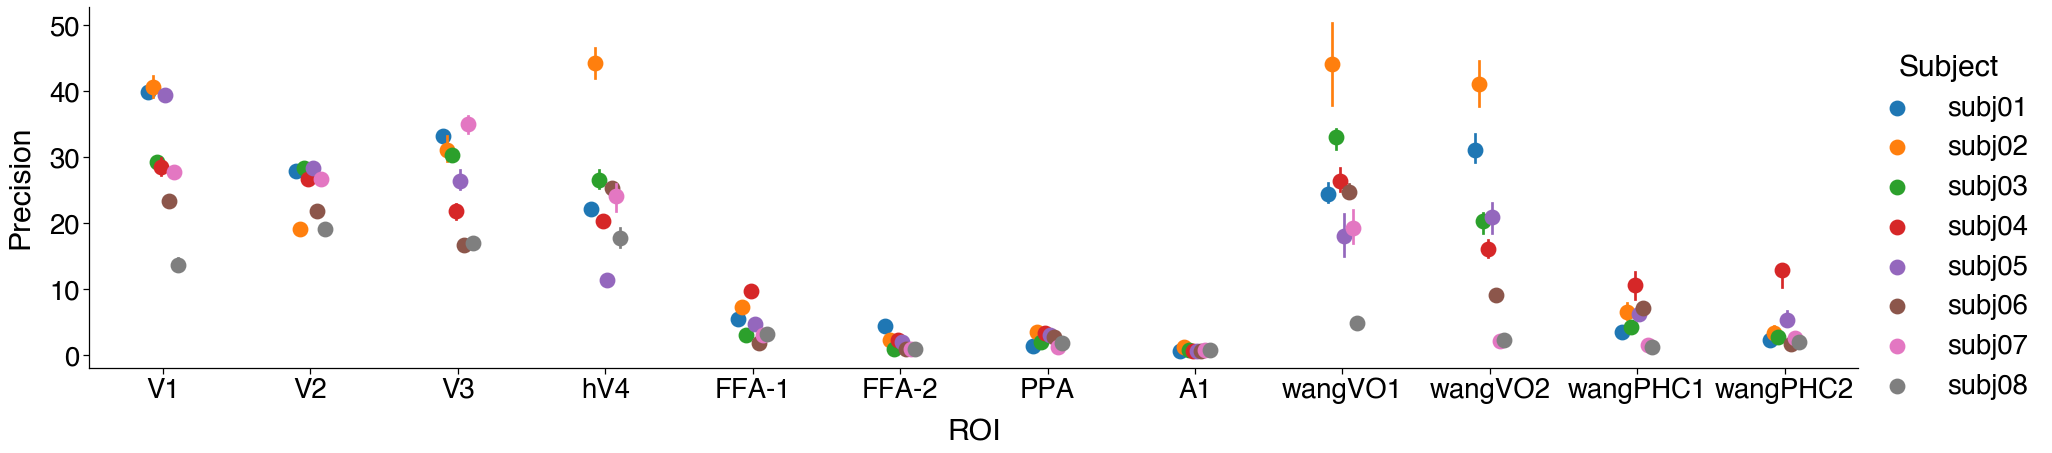

In [84]:
sns.set_context('notebook', font_scale=2.5)
roi_list= ['V1', 'V2','V3', 'hV4', 'FFA-1','FFA-2','PPA','A1','wangVO1','wangVO2','wangPHC1','wangPHC2']
save_path = os.path.join(fig_dir,'sfp_maps','mgzs','nsdsyn', 'quantification', 'fig-all_roi_precision.png')

grid = sns.FacetGrid(all_df,
                     height=7, aspect=3.8,
                     legend_out=True,
                     sharex=False, sharey=True)
g = grid.map(sns.pointplot, "ROI", "value", 'sub', order=roi_list,
             hue_order=sn_list, palette=sns.color_palette("tab10"), edgecolor='black',linewidth=1, linestyles='',joint=False,errorbar=('ci',68),
         estimator=np.median, alpha=0.8, orient="v",
         dodge=True, linestyle=None, scale=1.8)
for subplot_title, ax in grid.axes_dict.items():
    ax.set_title(f" ")
grid.set_axis_labels("ROI", 'Precision')
g.add_legend(title='Subject')
utils.save_fig(save_path)

# R2

In [85]:
hemi_rois, hemi_voxels = {}, {}
for sn, hemi in product(sn_list, ['lh','rh']):
    k=f'{sn}-{hemi}'
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    intersection_mask=os.path.join(output_dir,"sfp_maps","mgzs","nsdsyn", f"{hemi}.sub-{sn}_value-r2_frame-absolute.mgz")
    hemi_rois[k], hemi_voxels[k] = sfm.extract_roi_values(labels, label_dir, intersection_mask)
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)

In [86]:
medians_r2 = all_df.groupby(['sub','ROI'])['value'].median().reset_index()
medians_r2['roi_type'] = medians_precision.apply(lambda row: determine_value(row), axis=1)
all_df['roi_type'] = all_df.apply(lambda row: determine_value(row), axis=1)

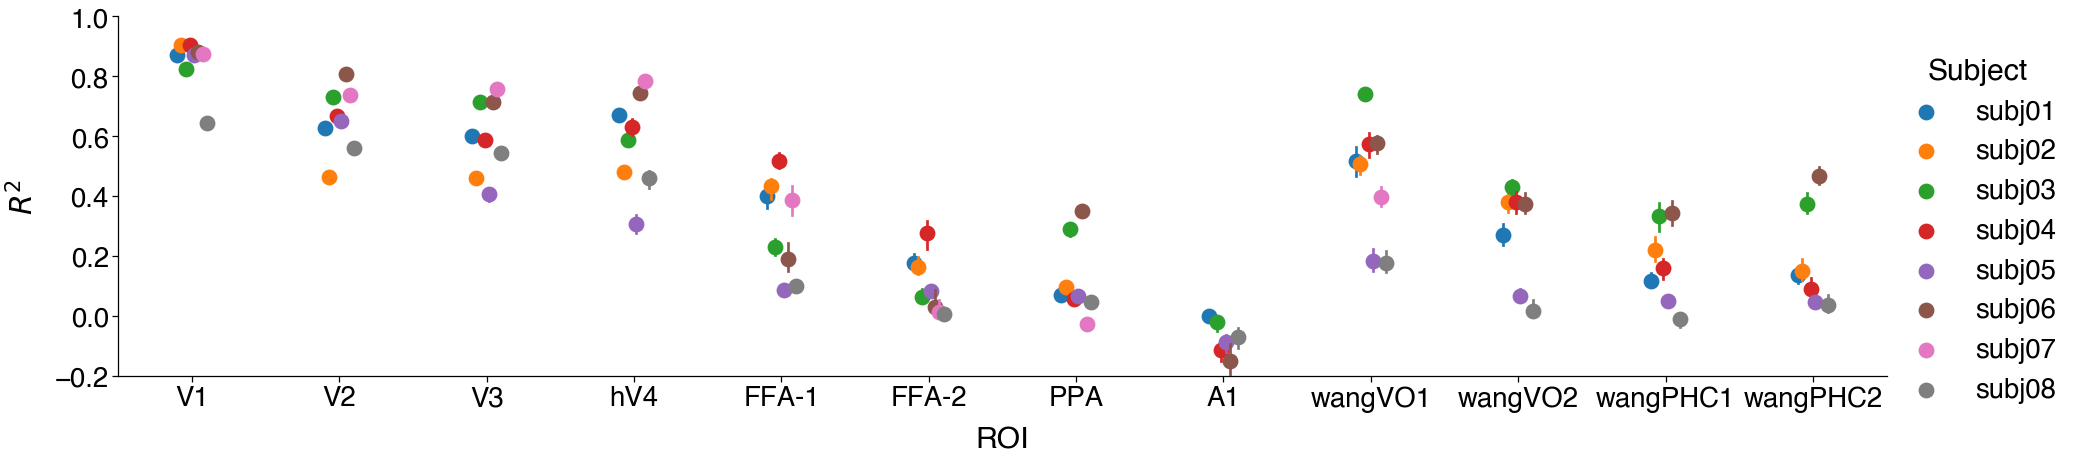

In [89]:
sns.set_context('notebook', font_scale=2.5)
roi_list= ['V1', 'V2','V3', 'hV4', 'FFA-1','FFA-2','PPA','A1','wangVO1','wangVO2','wangPHC1','wangPHC2']
save_path = os.path.join(fig_dir,'sfp_maps','mgzs','nsdsyn', 'quantification', 'fig-all_roi_r2.png')

grid = sns.FacetGrid(all_df,
                     height=7, aspect=3.8,
                     legend_out=True,
                     sharex=False, sharey=True)
g = grid.map(sns.pointplot, "ROI", "value", 'sub', order=roi_list,
             hue_order=sn_list, palette=sns.color_palette("tab10"), edgecolor='black',linewidth=1, linestyles='',joint=False,errorbar=('ci',68),
         estimator=np.median, alpha=0.8, orient="v",
         dodge=True, linestyle=None, scale=1.8)
g.set(ylim=(-0.2,1))
for subplot_title, ax in grid.axes_dict.items():
    ax.set_title(f" ")
grid.set_axis_labels("ROI", r"$R^2$")
g.add_legend(title='Subject')
utils.save_fig(save_path)

# Intersection

In [94]:
hemi_rois, hemi_voxels = {}, {}
for sn, hemi in product(sn_list, ['lh','rh']):
    k=f'{sn}-{hemi}'
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    intersection_mask=os.path.join(output_dir,"sfp_maps","mgzs","nsdsyn", f"{hemi}.mask-intersection_r2thres-{r2thres}_precisionthres-{precisionthres}_sub-{sn}_frame-{ref_frame}.mgz")
    hemi_rois[k], hemi_voxels[k] = sfm.extract_roi_values(labels, label_dir, intersection_mask)
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)

In [97]:
percent_df = all_df.groupby(['sub','ROI'])['value'].median().reset_index()
percent_df['roi_type'] = all_df.apply(lambda row: determine_value(row), axis=1)

ValueError: cannot reindex from a duplicate axis

In [100]:
all_df['value_percent'] = all_df['value']*100

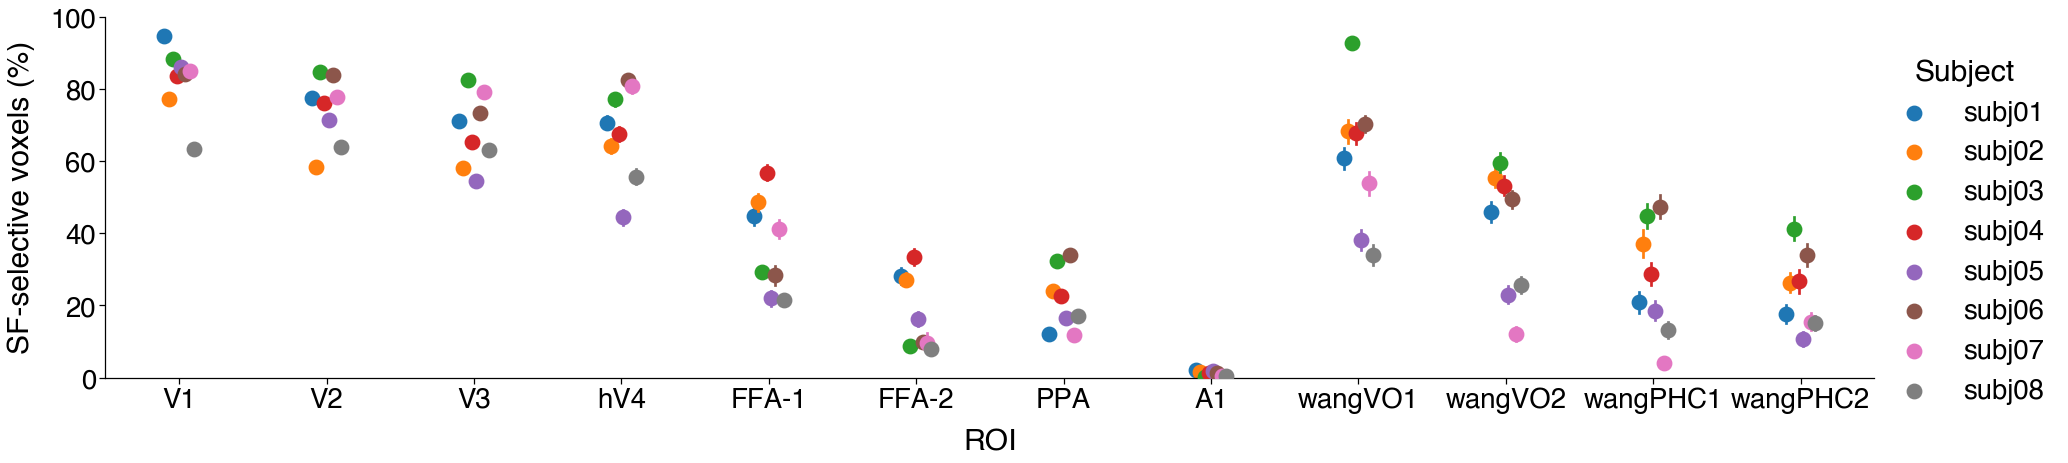

In [102]:
sns.set_context('notebook', font_scale=2.5)
roi_list= ['V1', 'V2','V3', 'hV4', 'FFA-1','FFA-2','PPA','A1','wangVO1','wangVO2','wangPHC1','wangPHC2']
save_path = os.path.join(fig_dir,'sfp_maps','mgzs','nsdsyn', 'quantification', 'fig-all_roi_intersection.png')

grid = sns.FacetGrid(all_df,
                     height=7, aspect=3.8,
                     legend_out=True,
                     sharex=False, sharey=True)
g = grid.map(sns.pointplot, "ROI", "value_percent", 'sub', order=roi_list,
             hue_order=sn_list, palette=sns.color_palette("tab10"), edgecolor='black',linewidth=1, linestyles='',joint=False,errorbar=('ci',68),
         estimator=np.mean, alpha=0.8, orient="v",
         dodge=True, linestyle=None, scale=1.8)
g.set(ylim=(0,100))
for subplot_title, ax in grid.axes_dict.items():
    ax.set_title(f" ")
grid.set_axis_labels("ROI", r"SF-selective voxels (%)")
g.add_legend(title='Subject')
utils.save_fig(save_path)

# Base sfp

In [23]:
# Define a custom function to determine the value of the new column
def determine_value(row):
    if row['ROI'] in ['V1', 'V2','V3', 'hV4','FFA-1','FFA-2','PPA','A1']:
        return 'ret'
    elif row['ROI'] in ['FFA-1','FFA-2','PPA']:
        return 'cat'
    elif row['ROI'] in ['wangVO1', 'wangVO2', 'wangPHC1','wangPHC2']:
        return 'vo-areas'


# Apply the function to the 'ROI' column to create a new column 'NewColumn'

In [24]:
hemi_rois, hemi_voxels = {}, {}
for sn, hemi in product(sn_list, ['lh','rh']):
    k=f'{sn}-{hemi}'
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    intersection_mask=os.path.join(output_dir,"sfp_maps","mgzs","nsdsyn", f"{hemi}.mask-intersection_r2thres-0.3_precisionthres-2_sub-{sn}_value-mode_frame-{ref_frame}.mgz")
    hemi_rois[k], hemi_voxels[k] = sfm.extract_roi_values(labels, label_dir, intersection_mask)
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)
percent_df = all_df.groupby(['sub','ROI'])['value'].median().reset_index()
all_df['roi_type'] = all_df.apply(lambda row: determine_value(row), axis=1)
sns.set_context('notebook', font_scale=2.5)
roi_list= ['V1', 'V2','V3', 'hV4', 'FFA-1','FFA-2','PPA','wangVO1','wangVO2','wangPHC1','wangPHC2']


/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


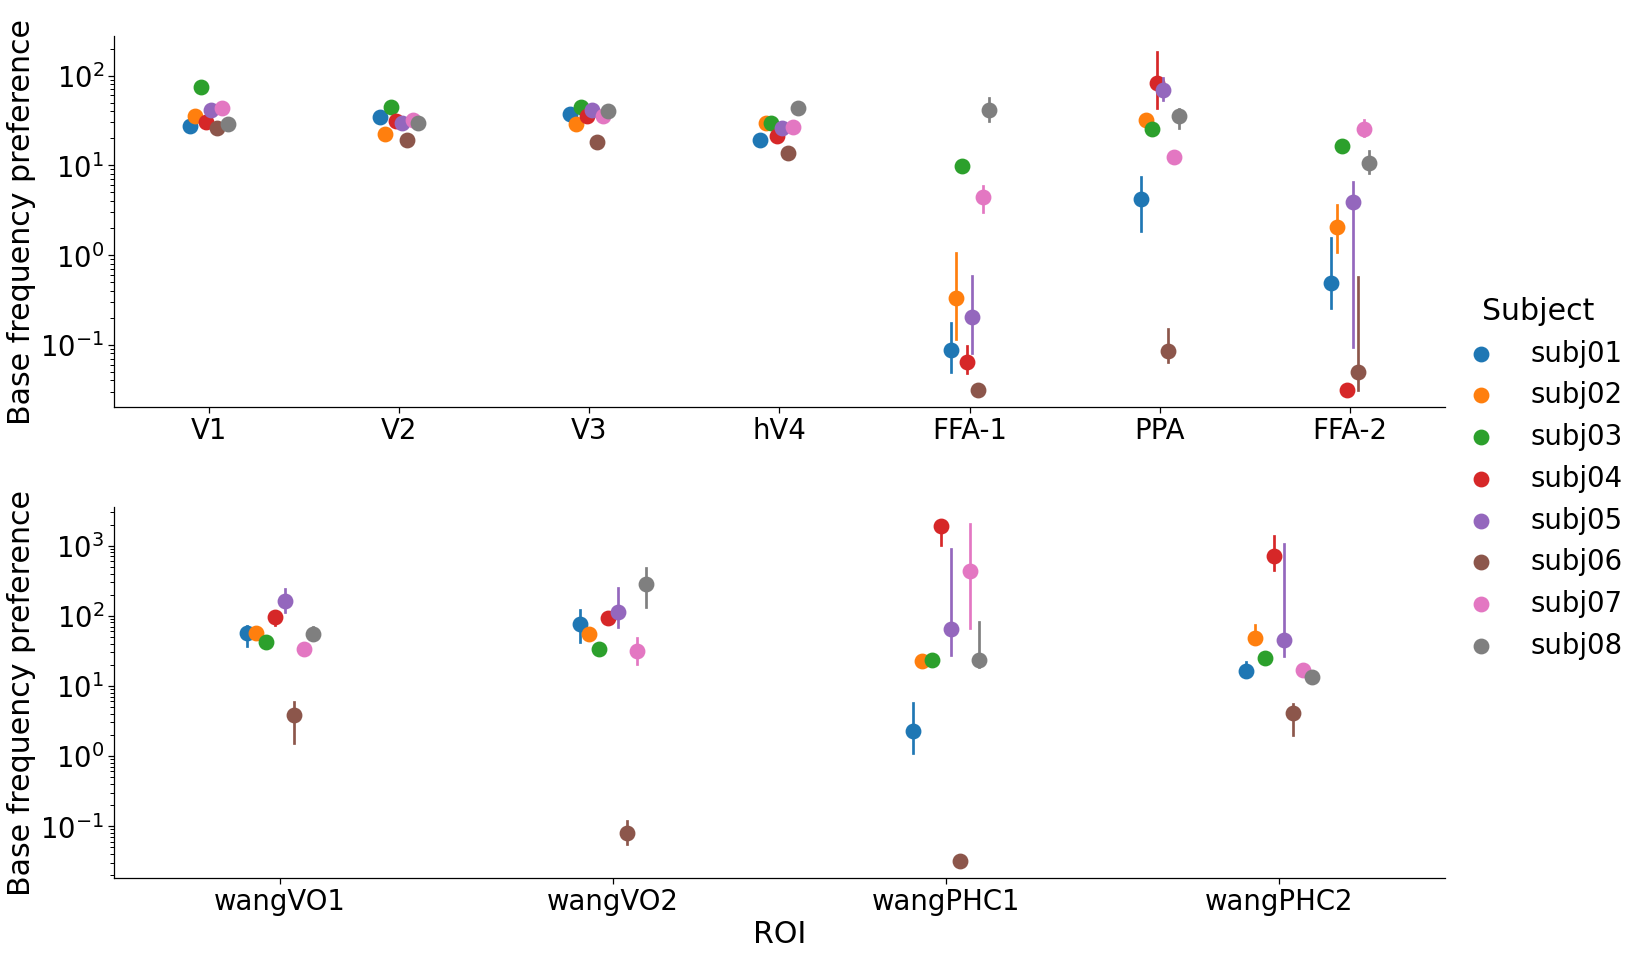

In [30]:
save_path = os.path.join(fig_dir,'sfp_maps','mgzs','nsdsyn', 'quantification', 'fig-all_roi_base-sfp.png')

grid = sns.FacetGrid(all_df.query('ROI != "A1"'),
                     height=7, aspect=3, row='roi_type',
                     legend_out=True,
                     sharex=False, sharey=False)
g = grid.map(sns.pointplot, "ROI", "value", 'sub',
             hue_order=sn_list, palette=sns.color_palette("tab10"), edgecolor='black',linewidth=1, linestyles='',joint=False,errorbar=('ci',68),
         estimator=np.median, alpha=0.8, orient="v",
         dodge=True, linestyle=None, scale=1.8)

g.set(yscale='log')
for subplot_title, ax in grid.axes_dict.items():
    ax.set_title(f" ")
grid.set_axis_labels("ROI", r"Base frequency preference")
g.add_legend(title='Subject')
utils.save_fig(save_path)

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


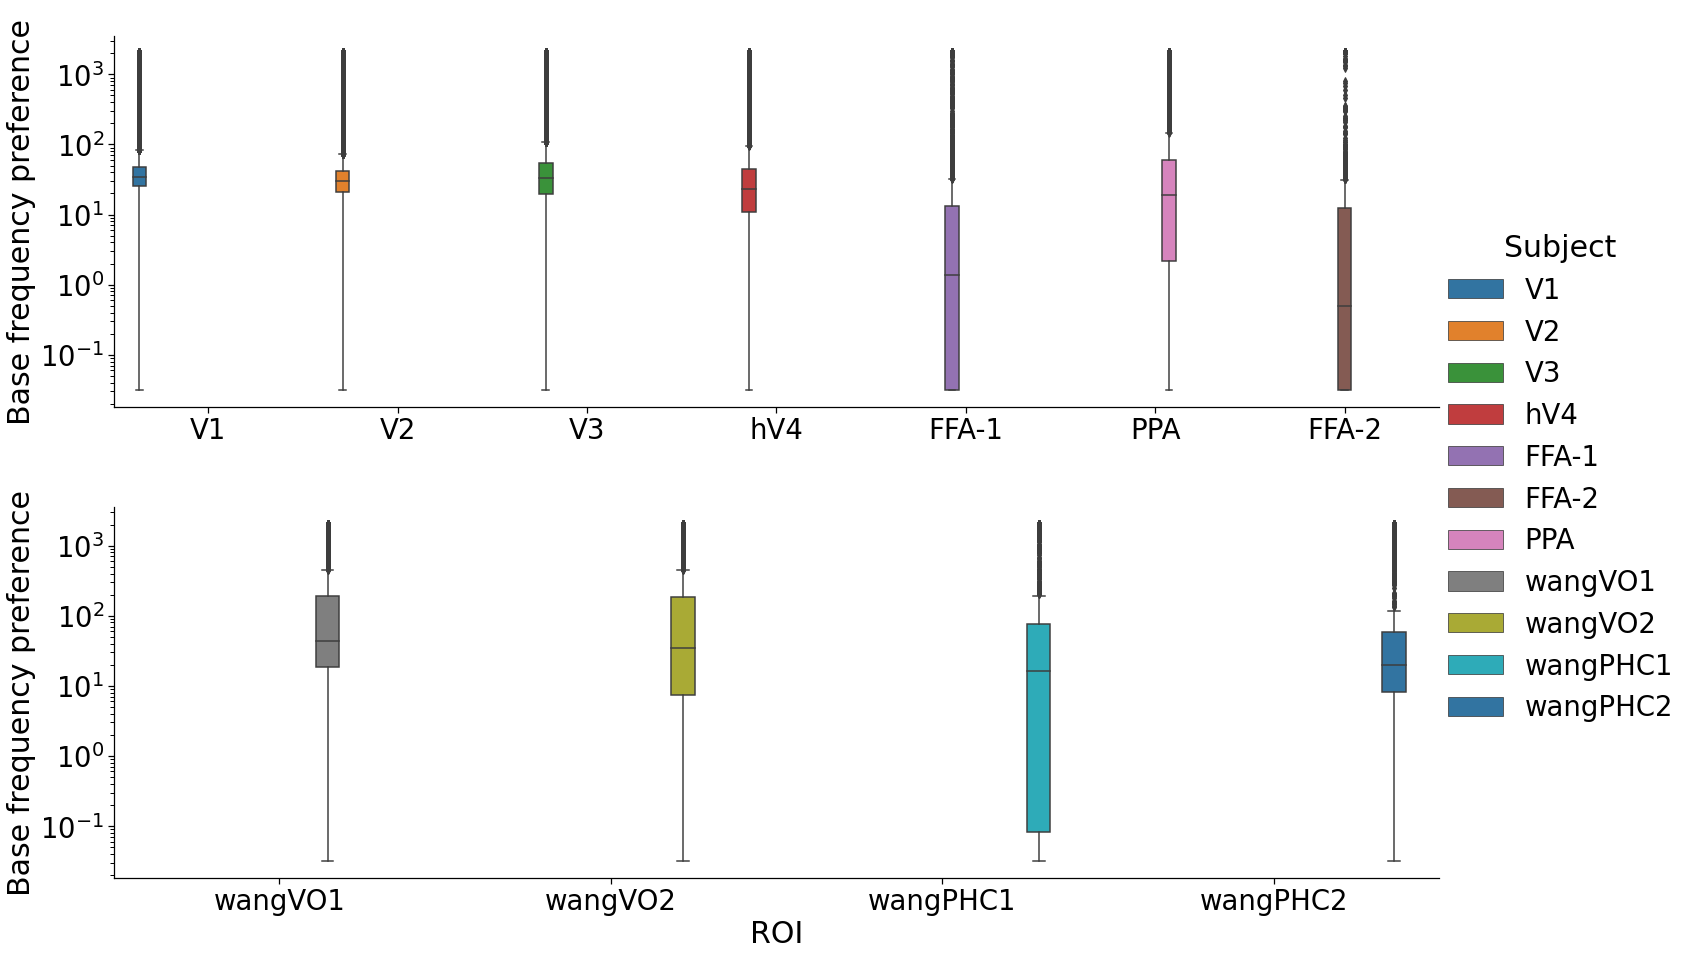

In [34]:
save_path = os.path.join(fig_dir,'sfp_maps','mgzs','nsdsyn', 'quantification', 'fig-box_all_roi_base-sfp.png')

grid = sns.FacetGrid(all_df.query('ROI != "A1"'),
                     height=7, aspect=3, row='roi_type',
                     legend_out=True,
                     sharex=False, sharey=False)
g = grid.map(sns.boxplot, "ROI", "value", 'ROI',
             hue_order=roi_list, palette=sns.color_palette("tab10"))

g.set(yscale='log')
for subplot_title, ax in grid.axes_dict.items():
    ax.set_title(f" ")
grid.set_axis_labels("ROI", r"Base frequency preference")
g.add_legend(title='Subject')
utils.save_fig(save_path)

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


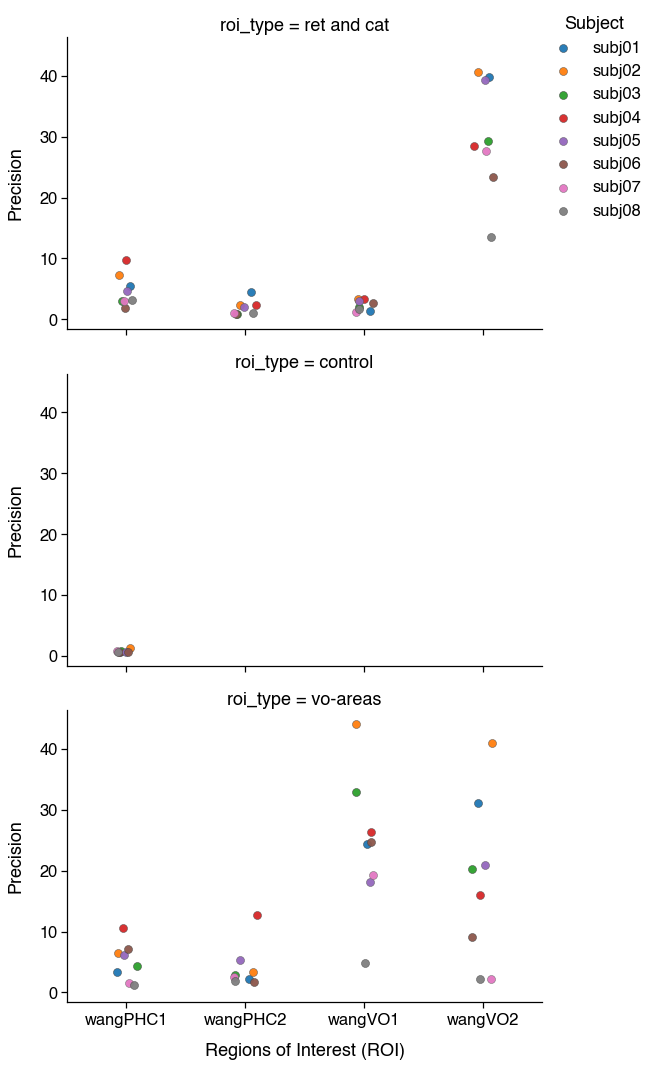

In [26]:
save_path = os.path.join(fig_dir, 'quantification', 'fig-precision.png')
roi_list= ['V1', 'V2','V3', 'hV4', 'FFA-1','FFA-2','PPA','A1','wangVO1','wangVO2','wangPHC1','wangPHC2']
g= vis1D.plot_median_for_each_sub_and_roi(medians_precision,
                                          'ROI', 'value', x_order=roi_list,
                                          row='roi_type', row_order=['ret and cat', 'control', 'vo-areas'],
                                           hue='sub',
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5,
                                           y_label="Precision",
                                          save_path=None)

In [44]:
hemi_rois, hemi_voxels = {}, {}
for sn, hemi in product(sn_list, ['lh','rh']):
    k=f'{sn}-{hemi}'
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    intersection_mask=os.path.join(output_dir,"sfp_maps","mgzs","nsdsyn", f"{hemi}.mask-intersection_r2thres-{r2thres}_precisionthres-{precisionthres}_sub-{sn}_frame-{ref_frame}.mgz")
    hemi_rois[k], hemi_voxels[k] = sfm.extract_roi_values(labels, label_dir, intersection_mask)
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)

In [2]:
all_df = sfm.breakdown_dfs(hemi_rois, hemi_voxels, sn_list)
all_df = utils.combine_dorsal_and_ventral_rois(all_df)

NameError: name 'sfm' is not defined

In [1]:
all_df

NameError: name 'all_df' is not defined

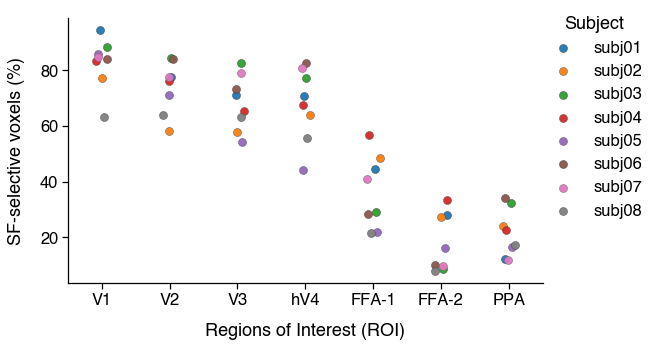

In [61]:
percent_df = all_df.groupby(['sub','ROI'])['value'].mean()*100
percent_df = percent_df.reset_index()
save_path = os.path.join(fig_dir, 'quantification', 'fig-sfselective.png')
roi_list=['V1','V2','V3','hV4','FFA-1','FFA-2','PPA']
g= vis1D.plot_median_for_each_sub_and_roi(percent_df,
                                          'ROI', 'value', x_order=roi_list,
                                           hue='sub',
                                           hue_order=sn_list,
                                           lgd_title='Subject',
                                           height=5,
                                           y_label=r"SF-selective voxels (%)",
                                          save_path=save_path)

In [60]:
save_path

'/Volumes/server/Projects/sfp_nsd/derivatives/figures/quantification/fig-sfselective.png'

In [ ]:
get_subject_colors(to_plot, dset='nsdsyn')

In [56]:
fig_dir

'/Volumes/server/Projects/sfp_nsd/derivatives/figures/'

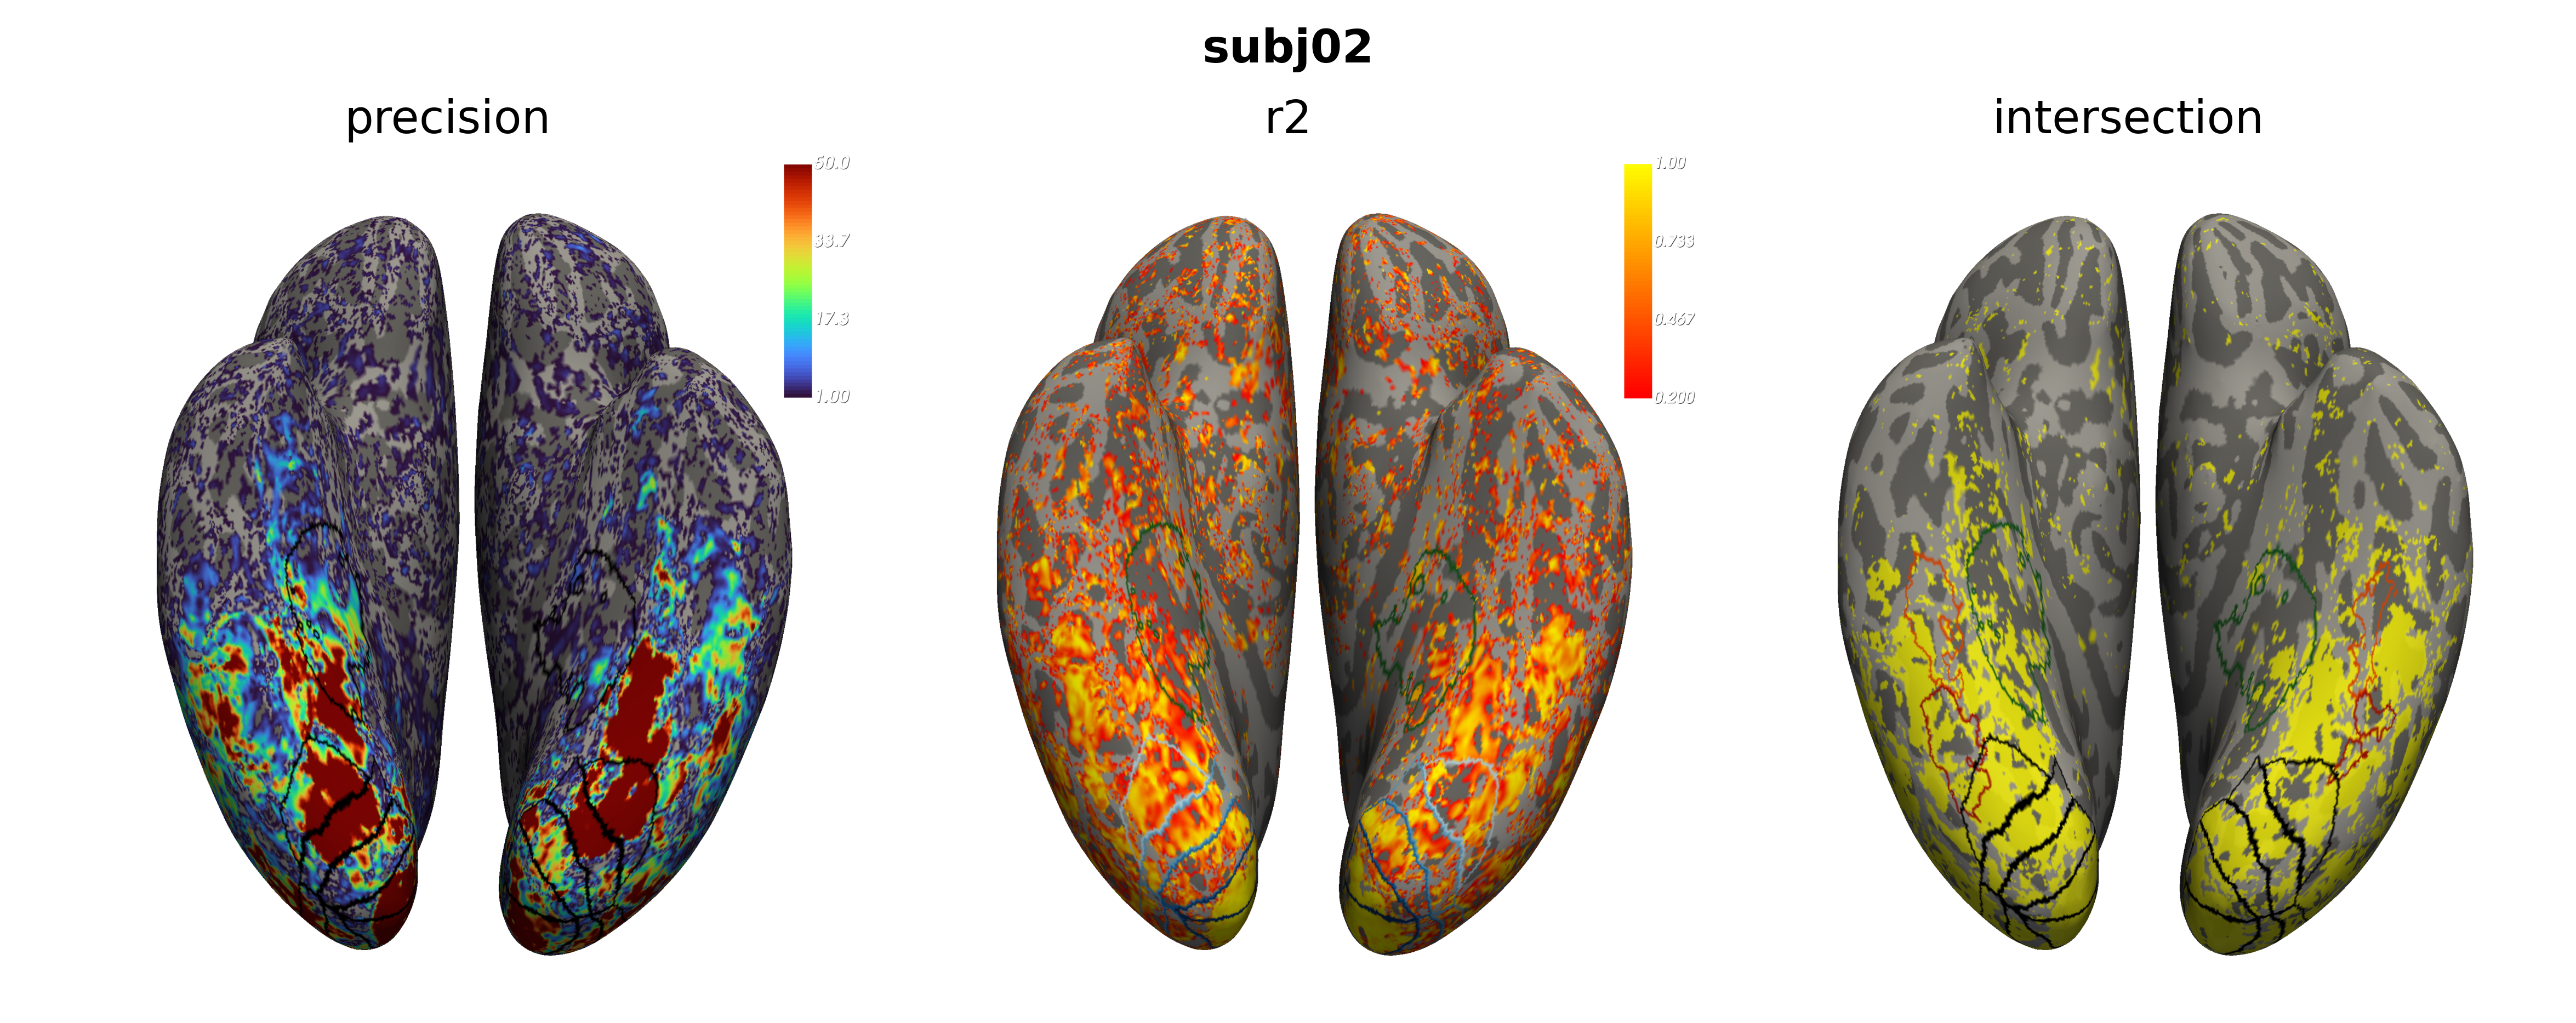

In [57]:
n_cols=3
cols=[precision, r2, intersection]
col_titles=['precision', 'r2', 'intersection']
pyview.plot_freeview_ss(n_cols, cols, col_titles, suptitle='subj02', dpi=500, save_path=os.path.join(fig_dir, 'test.png'))